In [1]:
from Helpers import *
from ILQGController import *
from FLController import *
from LQGController import *
#alacon

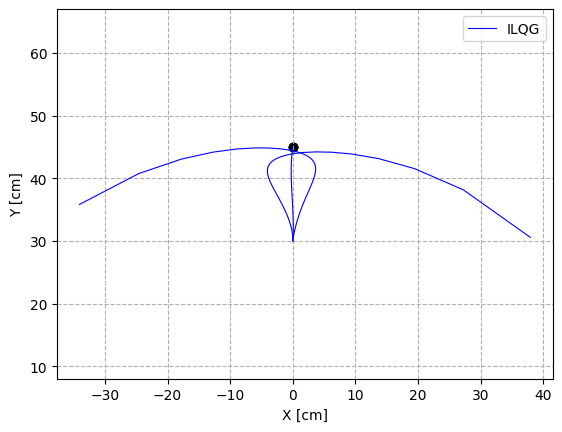

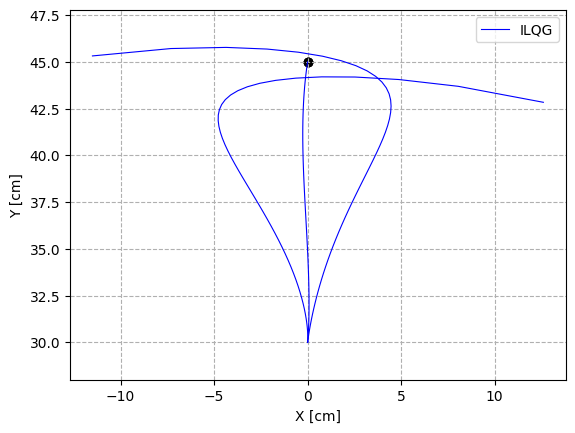

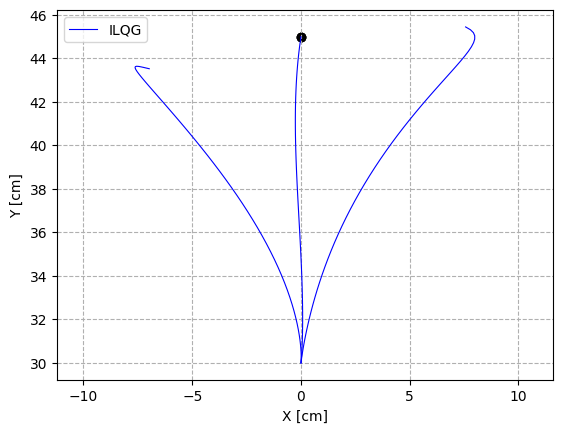

In [6]:

w1 = 1e7
w2 = 1e4
r1 = 1e-4
a = 1
for v in [1e-6,1e-7,1e-8]:
    x=ILQG(.6,w1,w2,r1,targets=[0,45],K = 60,start = [0,30],alpha = a,multvar=0,Noise=False,FF = False,Variance=v)
    x=ILQG(.6,w1,w2,r1,targets=[0,45],K = 60,start = [0,30],alpha = a,multvar=0,Noise=False,FF = True,Side = "Left",Variance=v)
    x=ILQG(.6,w1,w2,r1,targets=[0,45],K = 60,start = [0,30],alpha = a,multvar=0,Noise=False,FF = True,Side = "Right",Variance=v)
    plt.legend()
    MultipleLabel()
    plt.show()

In [2]:
def Plot_8_Target(K = 60,Noise = False,ClassicLQG = False,alpha = 1,multvar = 0):
    Duration = .6
    w1 = 1e7
    w2 = 1e4
    r1 = 1e-4
    d = 14.285
    start = [0,35]
    fig,ax = plt.subplots(figsize = (6,6),dpi = 600)
    TARG = [[0,55],[0,15],[20,35],[-20,35],[d,35+d],[d,35-d],[-d,35-d],[-d,35+d]]
    TEXTE = [[0,56],[0,12],[21,35],[-22,35],[d+.5,35+d+.5],[d+.5,35-d-2.5],[-d-1.5,35-d-2.5],[-d-1.5,35+d+.5]]
    for i in range(8):
        targets = TARG[i]
        plt.text(TEXTE[i][0],TEXTE[i][1],str(i))
        if ClassicLQG == True : xILQG,yILQG,_ = LQG(Duration,w1,w1,w2,w2,r1,r1,targets,Num_iter=60,starting_point=start,Activate_Noise = True,alpha = 1e-3)
        else : 
            xILQG,yILQG,uILQG,x = ILQG(Duration,w1,w2,r1,targets,60,start,Noise = Noise,alpha = alpha,multvar = multvar)
            J = 0
            R = np.array([[r1,0],[0,r1]])
            for j in range(K-1):
                J+= uILQG[j].T@R@uILQG[j]
            obj1,obj2 = newton(newtonf,newtondf,1e-8,1000,targets[0],targets[1]) #Defini les targets
    
            J+=(x[-1,2]*x[-1,2]+x[-1,3]*x[-1,3])*w2+w1*(x[-1,0]-obj1)**2+w1*(x[-1,1]-obj2)**2
            

            print("Total cost ILQG: "+str(J))   

            
        #X,Y,_ = LQG(Duration,w1,w1,w2,w2,r1,r1,targets,start,Num_iter = K,Activate_Noise = True)
        X,Y,_,_ = Feedback_Linearization(Duration,w1,w1,w2,w2,r1,r1,targets,start,Num_iter = 60,Activate_Noise=True,ShowJ= True,Delay =0,FF = False,alpha = alpha)

    hand, labl = ax.get_legend_handles_labels()
    handout=[]
    lablout=[]
    for h,l in zip(hand,labl):
        if l not in lablout:
            lablout.append(l)
            handout.append(h)
    fig.legend(handout, lablout)
    plt.xlim(-25,25)
    plt.ylim(10,60)
    plt.show()

In [ ]:
def Compute_Speed(X,Y,dt):
    V = np.zeros(X.shape[0])
    for i in range(X.shape[0]-1):
        V[i+1] = np.sqrt(((X[i+1]-X[i])/dt)**2+((Y[i+1]-Y[i])/dt)**2)
    return V

def Plot_Speed(K = 60,Noise = False,ClassicLQG = False,NumTarg = 8,TargStart = 0,L = 20):
    Duration = .6
    fig,ax = plt.subplots(NumTarg,figsize=(8,8+3*(NumTarg-1)))
    w1 = 1e7
    w2 = 1e4
    r1 = 1e-4
    d = np.sqrt(L**2/2)
    start = [0,35]
    TARG = [[0,55],[0,15],[20,35],[-20,35],[d,35+d],[d,35-d],[-d,35-d],[-d,35+d]]
    TEXTE = [[0,56],[0,12],[21,35],[-22,35],[d+.5,35+d+.5],[d+.5,35-d-2.5],[-d-1.5,35-d-2.5],[-d-1.5,35+d+.5]]
    for i in range(TargStart,TargStart+NumTarg):
        targets = TARG[i]
        if ClassicLQG == True : 
            xILQG,yILQG,_ = LQG(Duration,w1,w1,w2,w2,r1,r1,targets,Num_iter=60,starting_point=start,Activate_Noise = Noise,alpha = 1e-3,plot= False)
            
        else : 
            xILQG,yILQG,uILQG,x = ILQG(Duration,w1,w2,r1,targets,60,start,Noise = Noise,Variance=1e-6,plot= False)
            J = 0
            R = np.array([[r1,0],[0,r1]])
            for j in range(K-1):
                J+= uILQG[j].T@R@uILQG[j]
            

            print("Total cost ILQG: "+str(J))   
        
        V = Compute_Speed(xILQG,yILQG,Duration/K)
        if NumTarg > 1 :
            ax[i].plot(np.arange(0,Duration,Duration/K)[:-1],V,label = "LQG")   
            #X,Y,_ = LQG(Duration,w1,w1,w2,w2,r1,r1,targets,start,Num_iter = K,Activate_Noise = True)
            X,Y,u,J = Feedback_Linearization(Duration,w1,w1,w2,w2,r1,r1,targets,start,Num_iter = 60,Activate_Noise=Noise,ShowJ= True,Delay =0,FF = False,alpha = .08,plot = False)
            V = Compute_Speed(X,Y,Duration/K)
            ax[i].plot(np.arange(0,Duration,Duration/K),V,label = "FL") 
            ax[i].set_title("Target "+str(i))
            ax[i].legend()
            ax[i].set_xlabel("Time [s]")
            ax[i].set_ylabel("Velocity [m/s]")
        else : 
            ax.plot(np.arange(0,Duration,Duration/K)[:-1],V,label = "LQG")   
            #X,Y,_ = LQG(Duration,w1,w1,w2,w2,r1,r1,targets,start,Num_iter = K,Activate_Noise = True)
            X,Y,u,J = Feedback_Linearization(Duration,w1,w1,w2,w2,r1,r1,targets,start,Num_iter = 60,Activate_Noise=Noise,ShowJ= True,Delay =0,FF = False,alpha = .08,plot = False)
            V = Compute_Speed(X,Y,Duration/K)
            ax.plot(np.arange(0,Duration,Duration/K),V,label = "FL") 
            ax.set_title("Target "+str(i))
            ax.set_xlabel("Time [s]")
            ax.set_ylabel("Velocity [m/s]")
            ax.legend()
    plt.show()

Total cost of FL: 0.01507


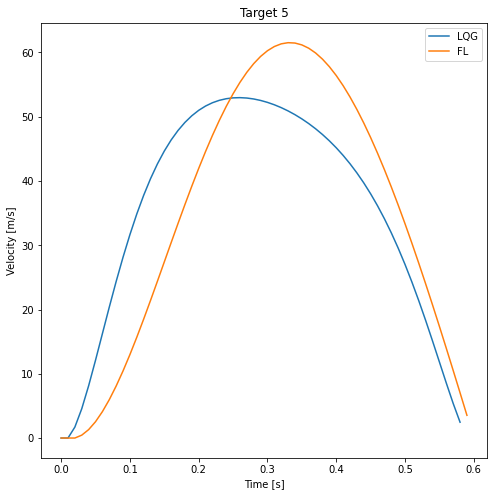

In [80]:
Plot_Speed(ClassicLQG=True,NumTarg = 1,TargStart = 5)

Total cost of FL: 0.00807


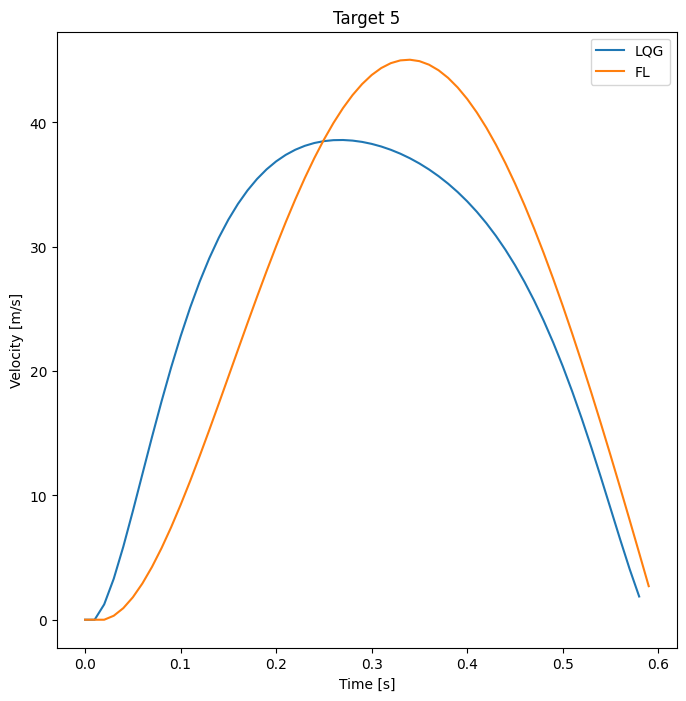

In [10]:
Plot_Speed(ClassicLQG=True,NumTarg = 1,TargStart = 5, L = 15)

Total cost ILQG: 969.5713663672005
Total cost of FL: 511.439
Total cost ILQG: 4436.7910567162035
Total cost of FL: 386.742
Total cost ILQG: 5088.759411930284
Total cost of FL: 141.802
Total cost ILQG: 428.7740492437751
Total cost of FL: 140.604
Total cost ILQG: 905.9834004138262
Total cost of FL: 325.822
Total cost ILQG: 228.69418933104473
Total cost of FL: 298.215
Total cost ILQG: 7063.195147928701
Total cost of FL: 112.770
Total cost ILQG: 2656.8439387823155
Total cost of FL: 493.122


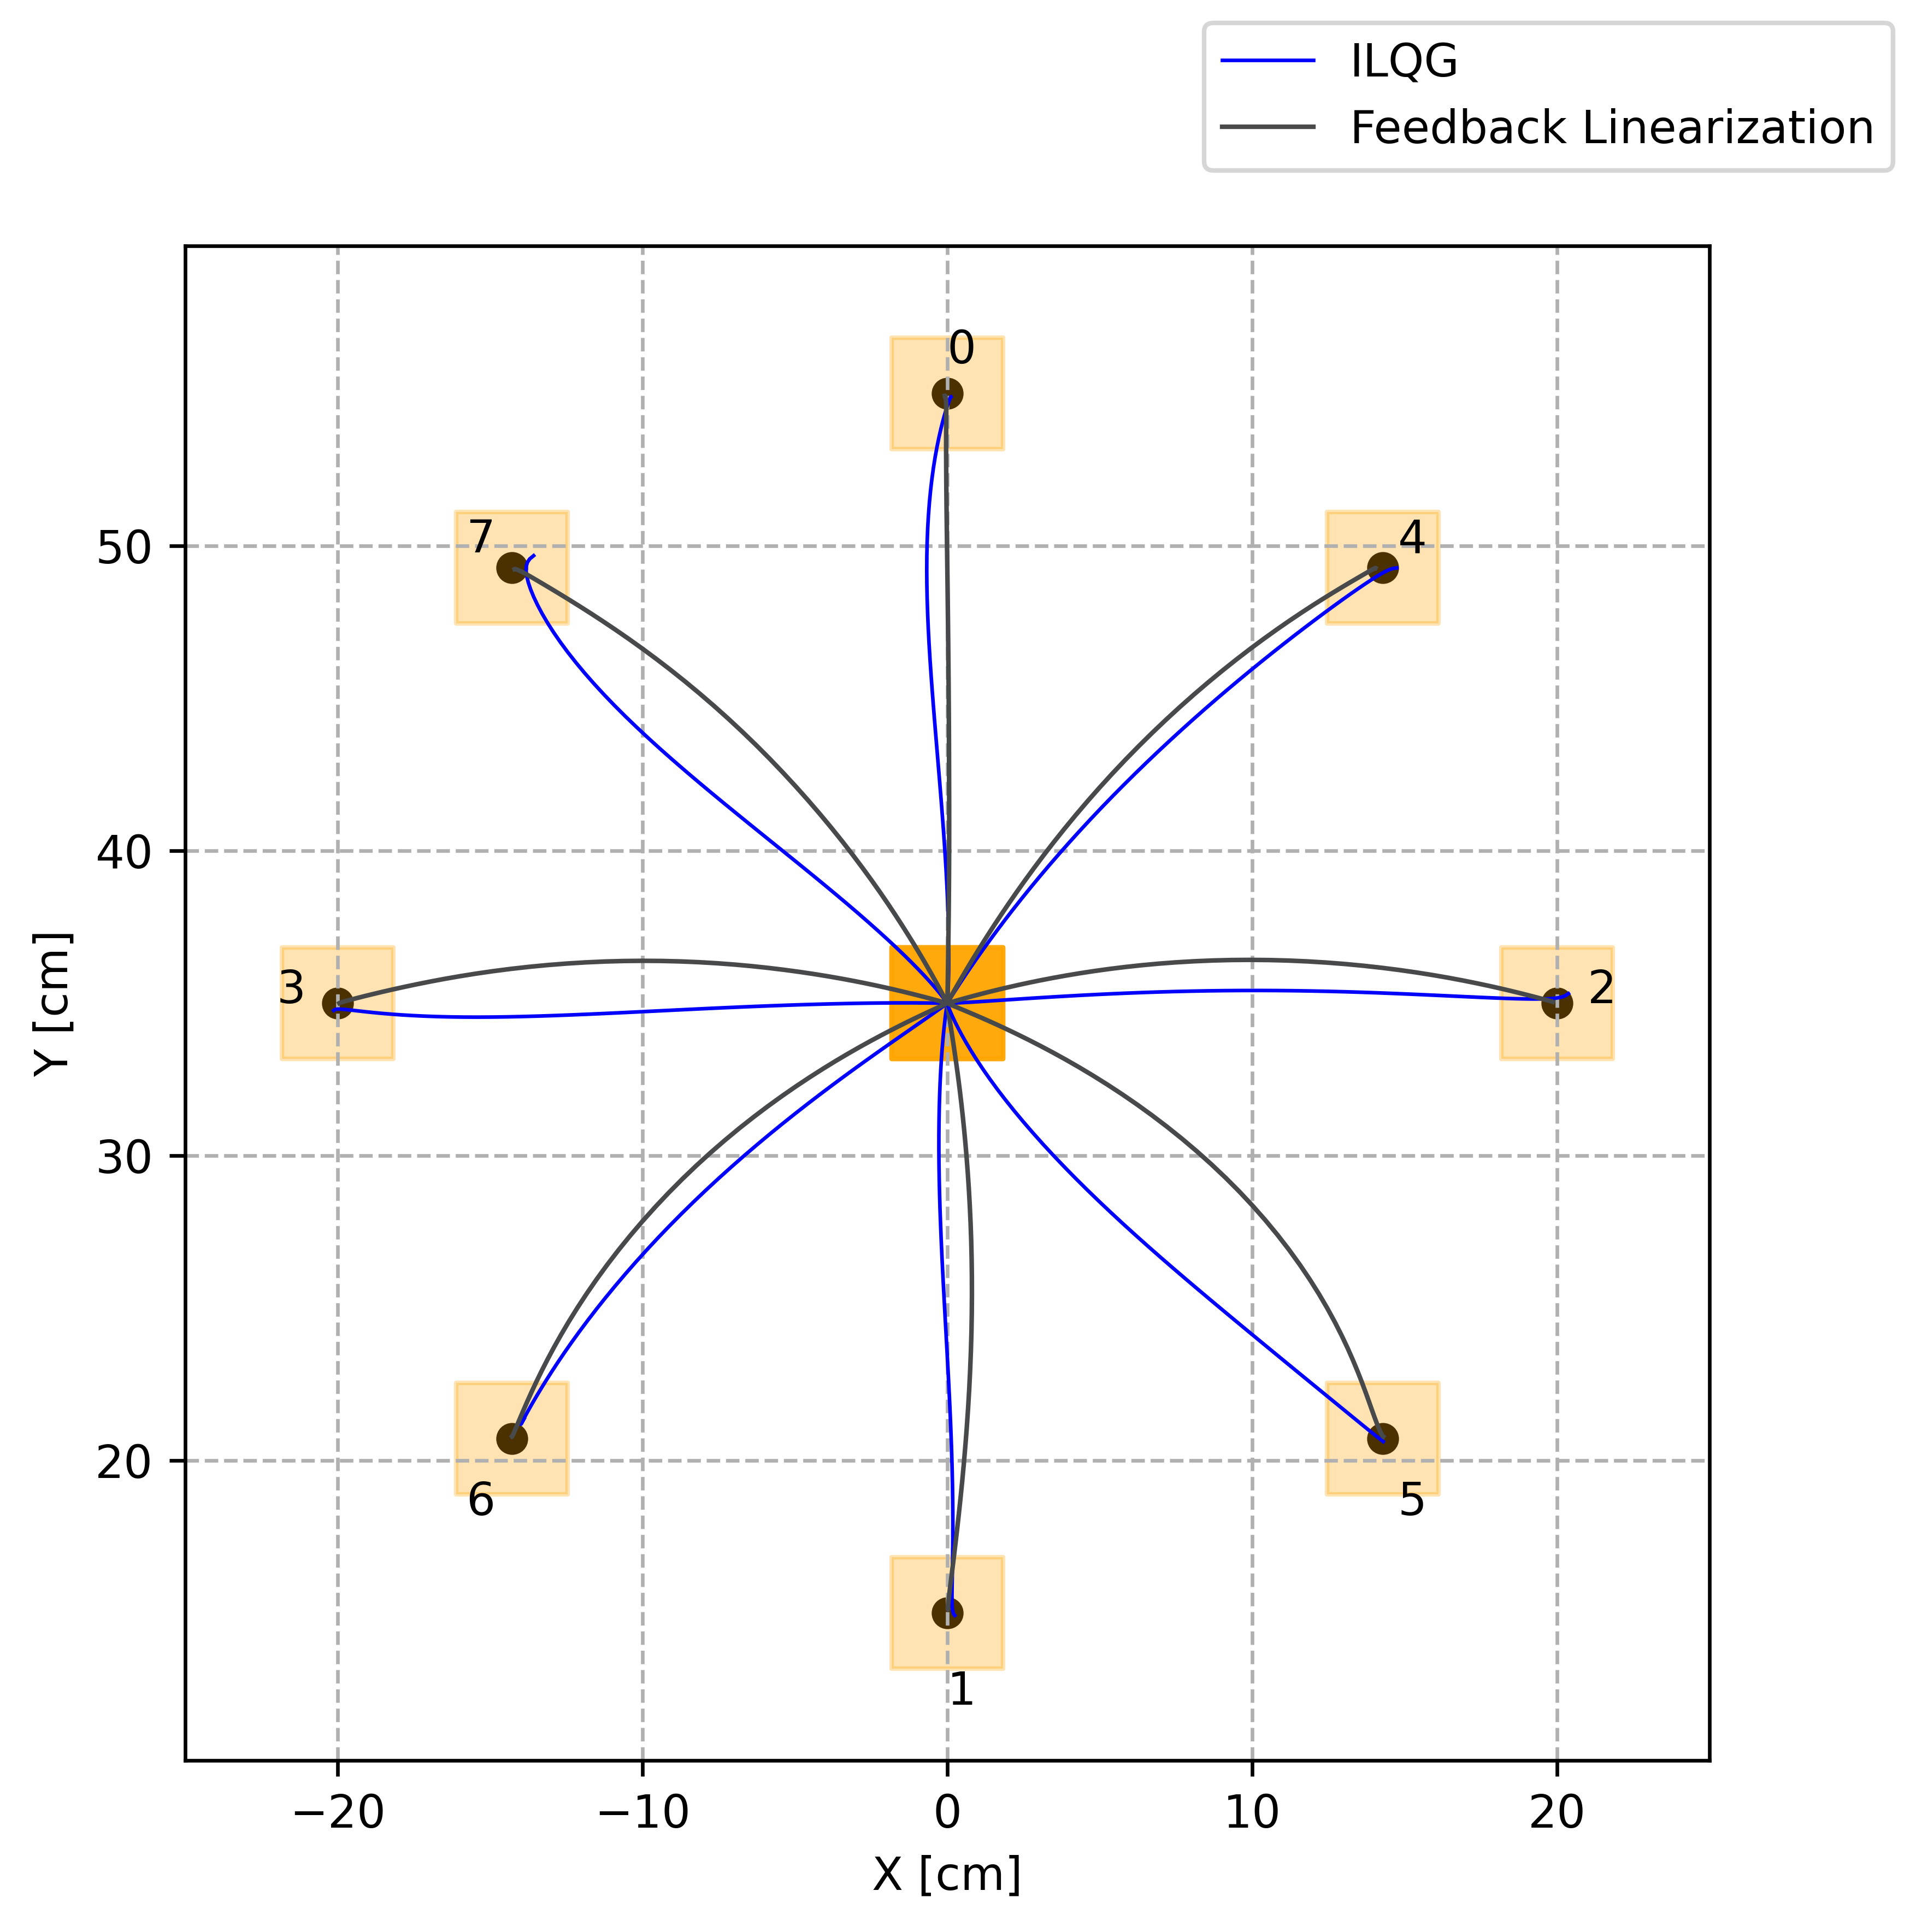

In [13]:
Plot_8_Target(Noise=True,alpha = 1e-2)

Total cost ILQG: 0.00835916054240203
Total cost ILQG: 0.005989986803645634
Total cost ILQG: 0.005467046964720924
Total cost ILQG: 0.009408408277047397
Total cost ILQG: 0.003647433901983947
Total cost ILQG: 0.011998602935241204
Total cost ILQG: 0.004878849310519756
Total cost ILQG: 0.011533680435456706


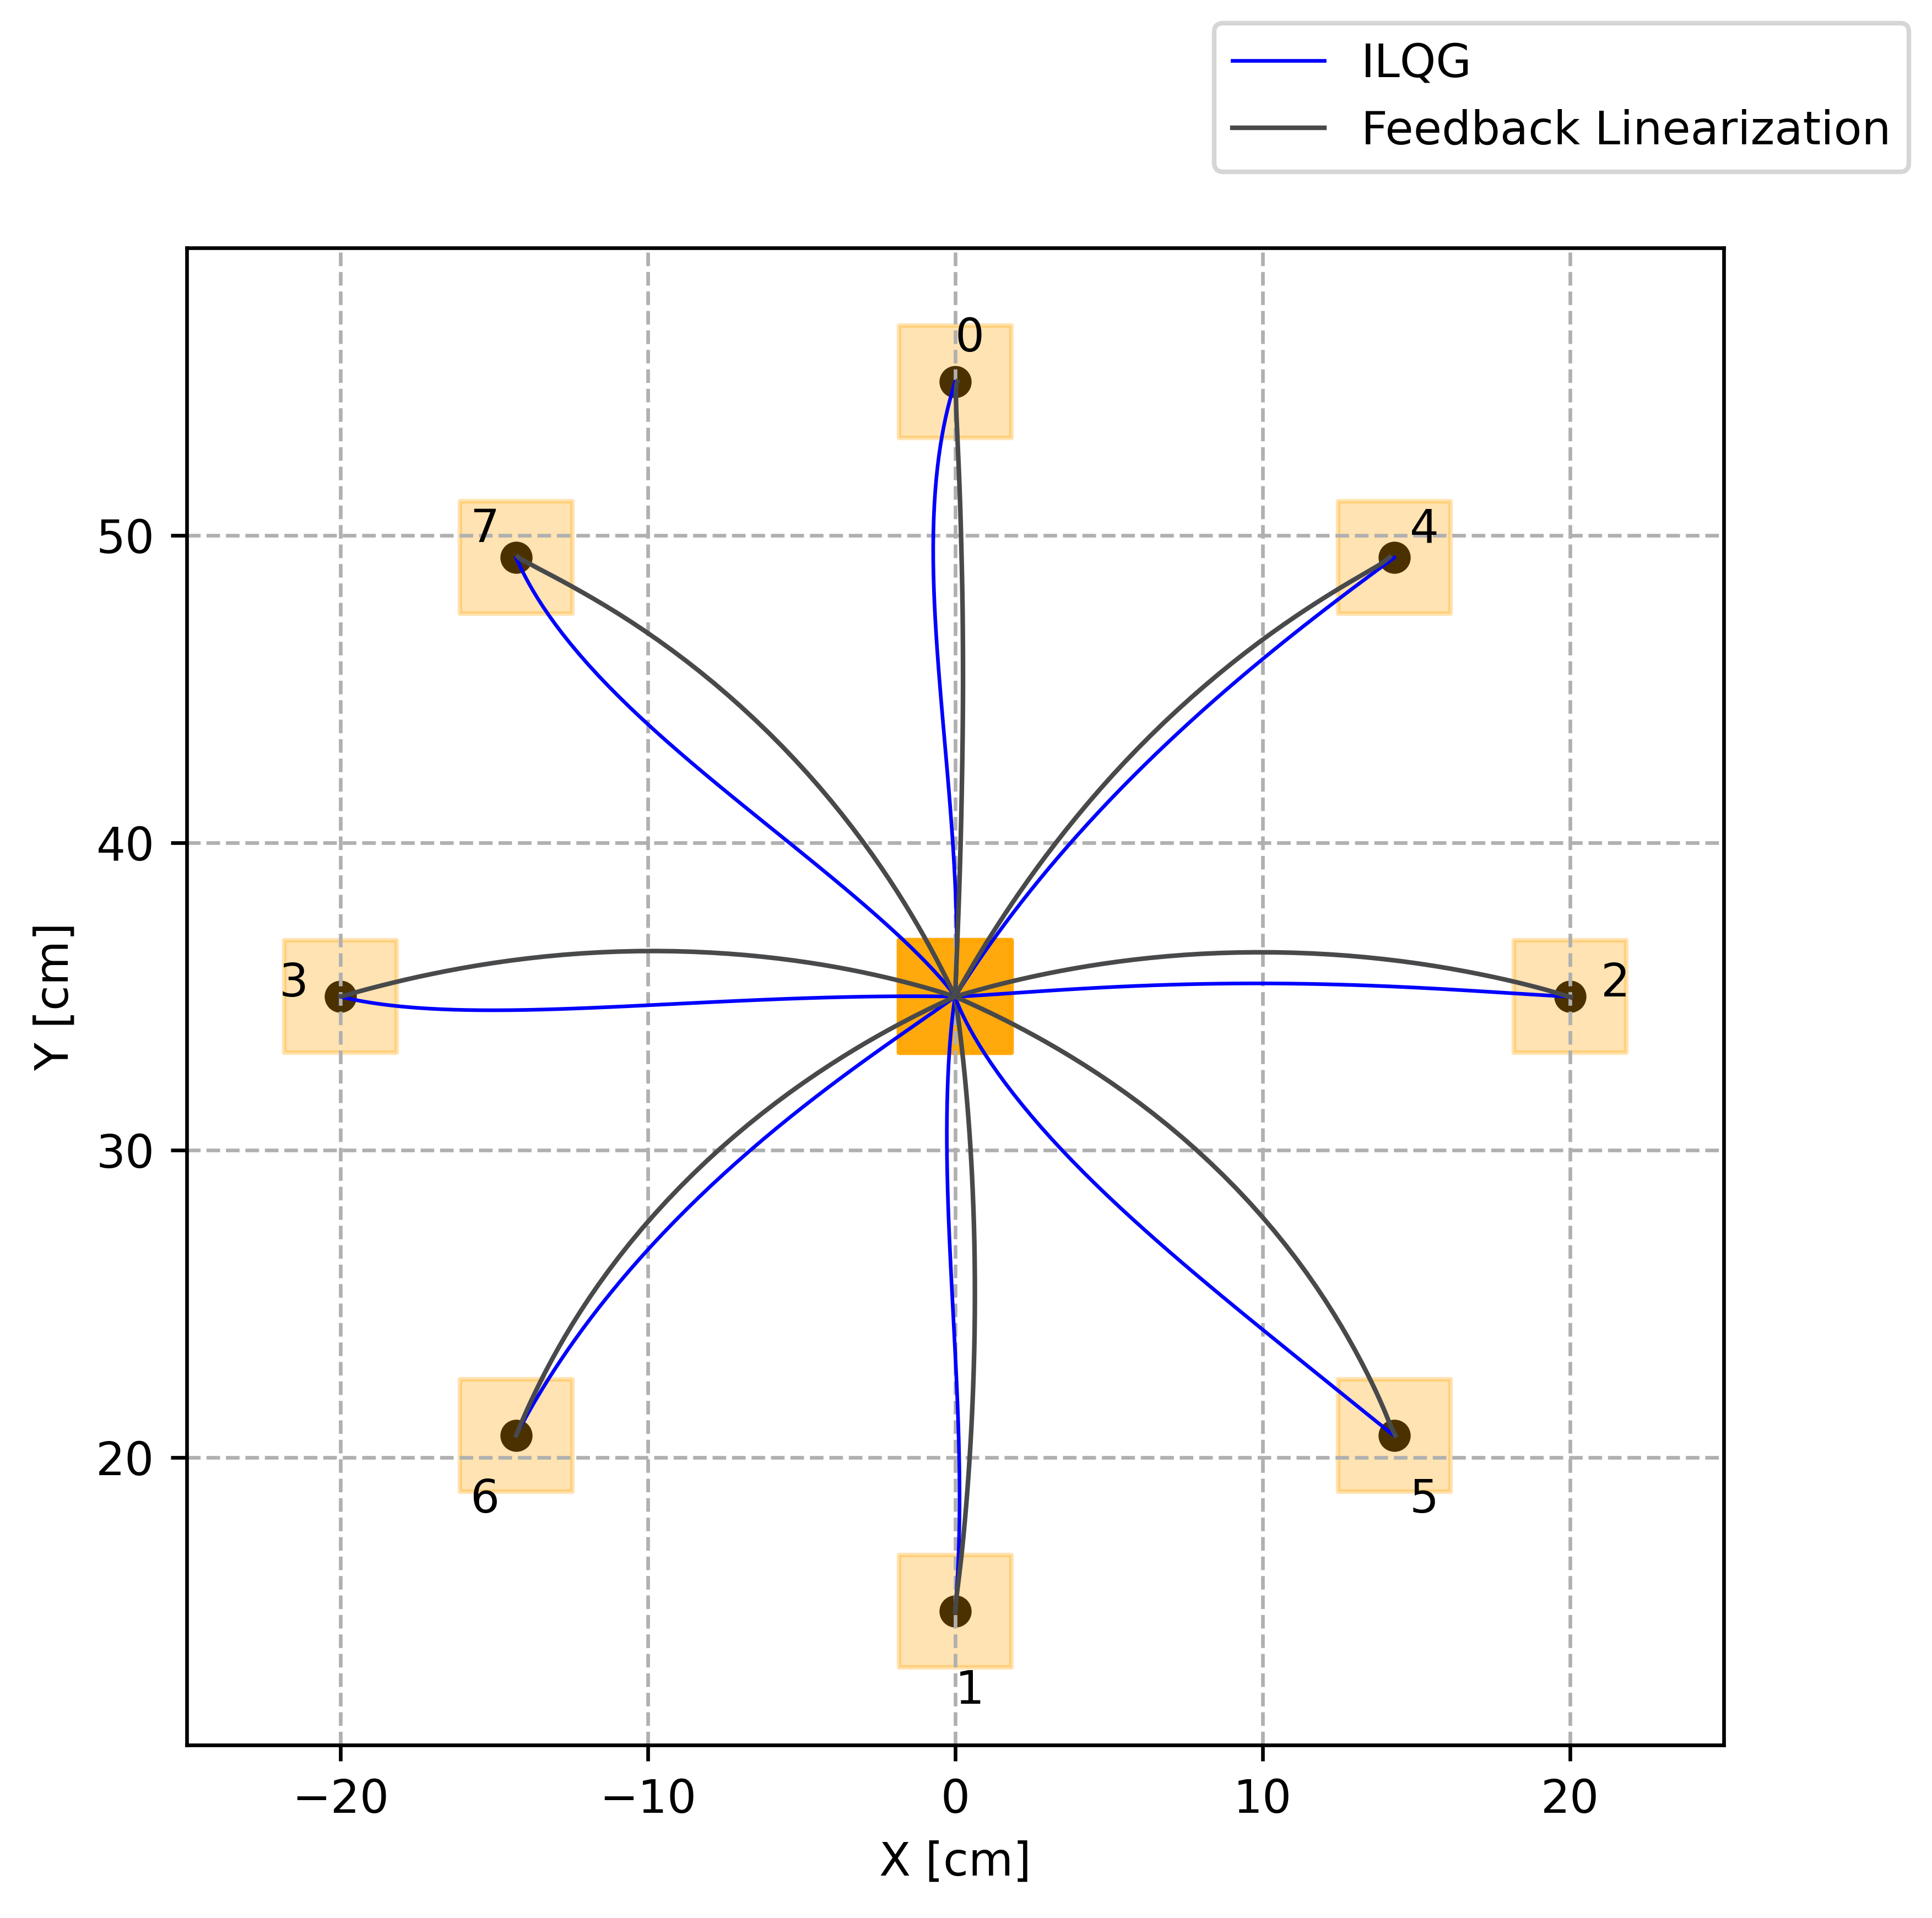

In [12]:
Plot_8_Target(Noise = True)

Total cost of FL: 0.00992
Total cost of FL: 0.00733
Total cost of FL: 0.00737
Total cost of FL: 0.01254
Total cost of FL: 0.00444
Total cost of FL: 0.01507
Total cost of FL: 0.00583
Total cost of FL: 0.01552


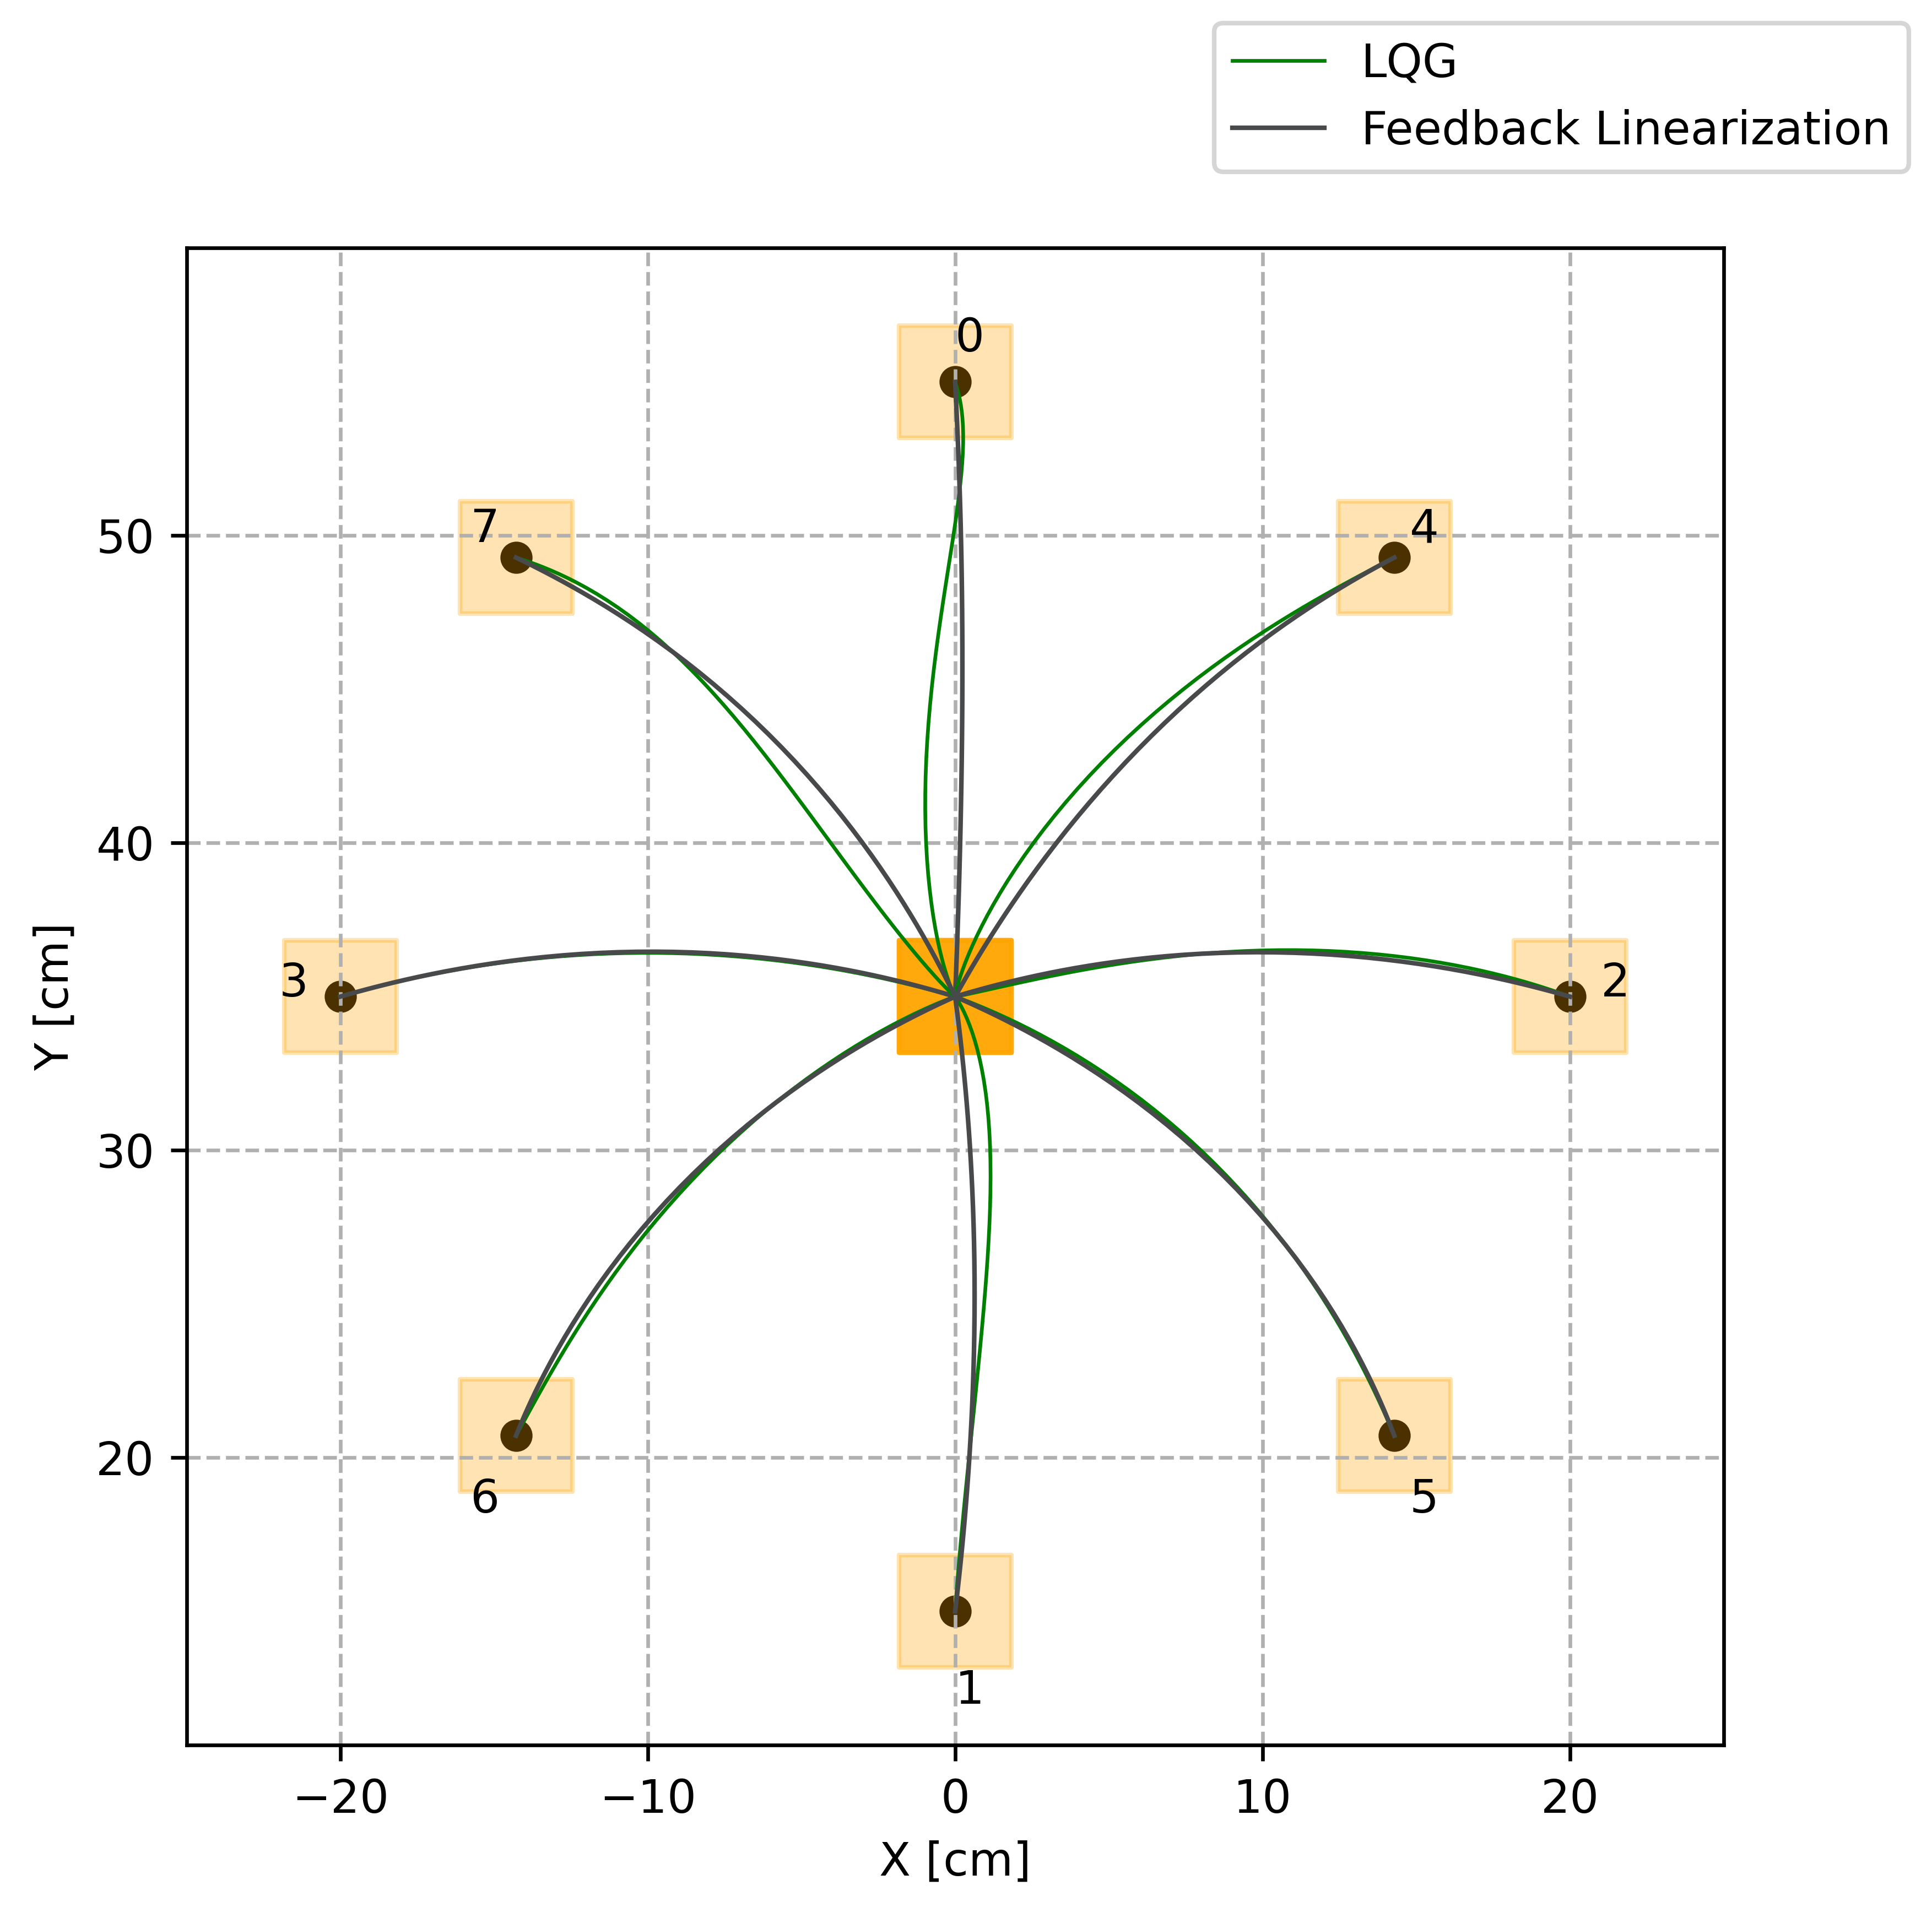

In [3]:
Plot_8_Target(Noise = False,ClassicLQG=True)

Total cost ILQG: 0.00835916054240203
Total cost of FL: 0.03528
Total cost ILQG: 0.005989986803645634
Total cost of FL: 0.01075
Total cost ILQG: 0.005467046964720924
Total cost of FL: 0.01892
Total cost ILQG: 0.009408408277047397
Total cost of FL: 0.01574
Total cost ILQG: 0.003647433901983947
Total cost of FL: 0.01221
Total cost ILQG: 0.011998602935241204
Total cost of FL: 0.01736
Total cost ILQG: 0.004878849310519756
Total cost of FL: 0.01078
Total cost ILQG: 0.011533680435456706
Total cost of FL: 0.02191


<Figure size 1440x1440 with 0 Axes>

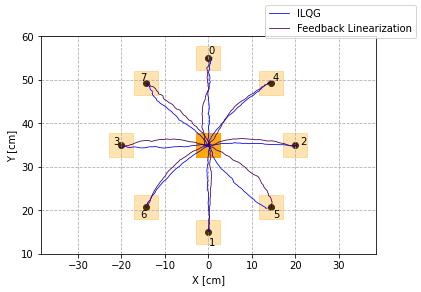

In [17]:
Plot_8_Target(Noise = True)

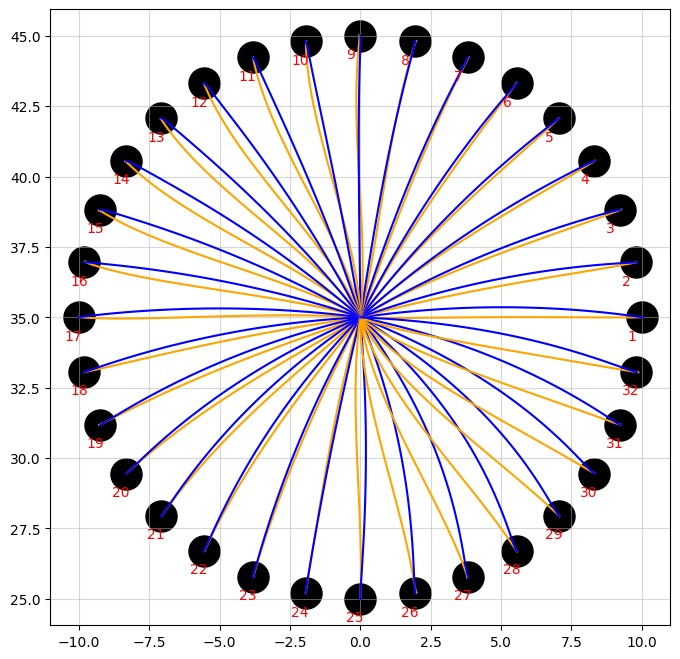

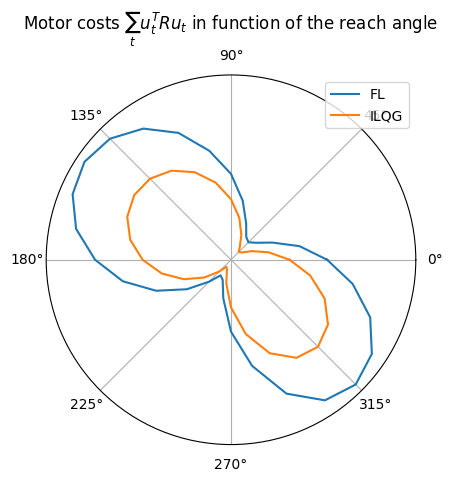

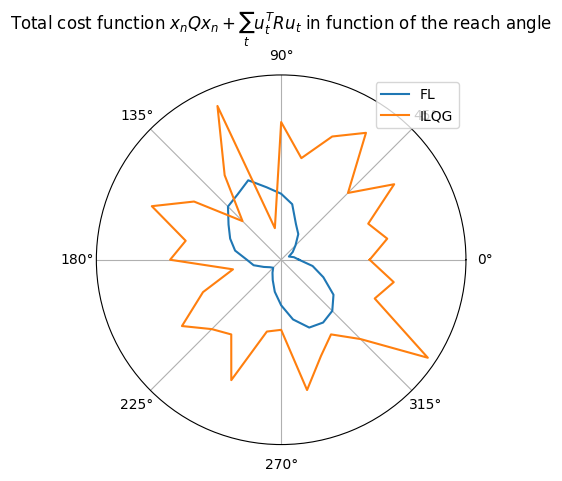

In [18]:
K = 60
Duration = .6
w1 = 1e8
w2 = 1e4
r1 = 1e-4
d = 14.285
start = [0,35]
L = 10
fig,ax = plt.subplots(figsize = (8,8))
alpha = 1000
PLOT = False
NUMTARG = 32
TARG = []

theta = np.linspace(0,2*pi,NUMTARG,endpoint=False)
for i in range(NUMTARG):
    TARG.append(start+np.array([L*cos(theta[i]),L*sin(theta[i])]))

COSTSFL = np.zeros(NUMTARG)
MOTORCOSTSFL= np.zeros(NUMTARG)
COSTSILQG = np.zeros(NUMTARG)
MOTORCOSTSILQG= np.zeros(NUMTARG)
NUMSIM = 10
NOISE = True

for sim in range(NUMSIM):
    for i in range(NUMTARG):
        if sim==0:
            plt.scatter(TARG[i][0],TARG[i][1],color = "black",s = 500)
            plt.text(TARG[i][0]-.5,TARG[i][1]-.8,str(i+1),color = "red",size =  10)
            #plt.plot(np.linspace(start[0],TARG[i][0]),np.linspace(start[1],TARG[i][1]),label = str(i+1))

        targets = TARG[i]
        obj1,obj2 = newton(fnewton,dfnewton,1e-8,1000,targets[0],targets[1])
        xtarg = np.array([obj1,obj2])
        #plt.text(TEXTE[i][0],TEXTE[i][1],str(i))
        xILQG,yILQG,uILQG,x = ILQG(Duration,w1,w2,r1,targets,K,start,Noise = NOISE,plot = PLOT,alpha = alpha,multvar = 0)
    
        J = 0
        R = np.array([[r1,0],[0,r1]])
        for j in range(K-1):
            J+= uILQG[j].T@R@uILQG[j]
        MOTORCOSTSILQG[i]+=(J/NUMSIM)
        J+= w1*((x[-1,0]-xtarg[0])*(x[-1,0]-xtarg[0])+(x[-1,1]-xtarg[1])*(x[-1,1]-xtarg[1])) + w2*(x[-1,2]*x[-1,2]+x[-1,3]*x[-1,3])
        COSTSILQG[i]+=(J/NUMSIM)
        X,Y,J,x = Feedback_Linearization(Duration,w1,w1,w2,w2,r1,r1,targets,start,FF=False,alpha=alpha,newtonfunc = fnewton,newtondfunc = dfnewton,Num_iter = K,ShowJ=True,plot = PLOT,Activate_Noise=NOISE,Delay=0)
        if sim==0: 
            plt.plot(xILQG,yILQG,color = "orange",label = "ILQG")
            plt.plot(X,Y,color = "blue",label = "FL")
            plt.axis("equal")
            plt.grid(alpha = .5)
        MOTORCOSTSFL[i]+=(J/NUMSIM)
        J+= w1*((x[0]-xtarg[0])*(x[0]-xtarg[0])+(x[1]-xtarg[1])*(x[1]-xtarg[1])) + w2*(x[2]*x[2]+x[3]*x[3])
        COSTSFL[i]+=(J/NUMSIM)
        #print("Finished target "+str(i))
#for i in range(8):
    #print("For Target Number "+str(i+1)+"\n"+"Total Cost of FL : "+str(COSTSFL[i])+"\n"+"Total Cost of ILQG : "+str(COSTSILQG[i])+"\n")

plt.show()

MOTORCOSTSILQG = np.append(MOTORCOSTSILQG,MOTORCOSTSILQG[0])
MOTORCOSTSFL= np.append(MOTORCOSTSFL,MOTORCOSTSFL[0])
COSTSILQG= np.append(COSTSILQG,COSTSILQG[0])
COSTSFL= np.append(COSTSFL,COSTSFL[0])
theta = np.append(theta,theta[0])

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, MOTORCOSTSFL,label = "FL")
ax.plot(theta, MOTORCOSTSILQG,label = "ILQG")
ax.grid(True)
ax.legend()
ax.set_yticks([])
ax.set_title("Motor costs $\sum_t u_t^TRu_t$ in function of the reach angle")
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_title("Total cost function $x_nQx_n+\sum_t u_t^TRu_t $ in function of the reach angle")
ax.plot(theta, COSTSFL,label = "FL")
ax.plot(theta, COSTSILQG,label = "ILQG")
ax.grid(True)
ax.set_yticks([])
ax.legend()
plt.show()


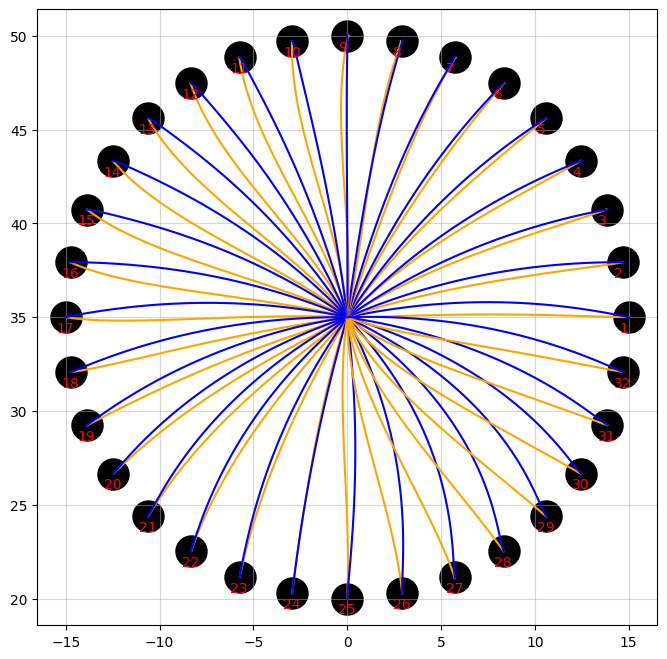

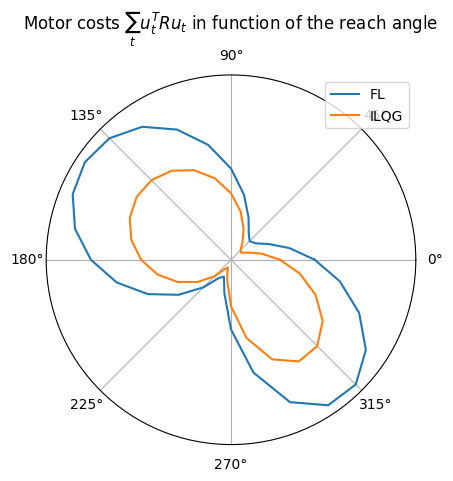

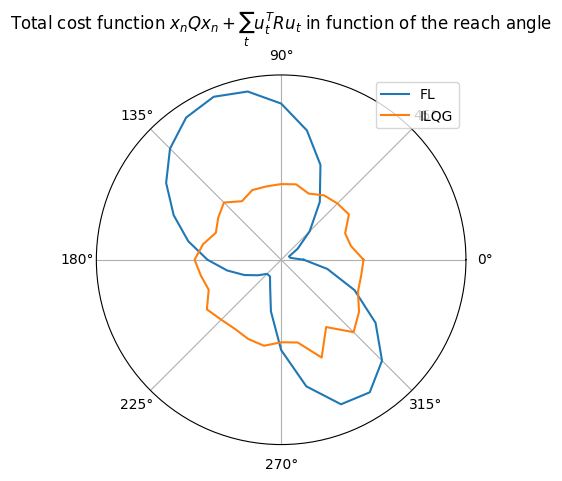

In [14]:
K = 60
Duration = .6
w1 = 1e8
w2 = 1e4
r1 = 1e-4
d = 14.285
start = [0,35]
L = 20
fig,ax = plt.subplots(figsize = (8,8))
alpha = 1000
PLOT = False
NUMTARG = 32
TARG = []

theta = np.linspace(0,2*pi,NUMTARG,endpoint=False)
for i in range(NUMTARG):
    TARG.append(start+np.array([L*cos(theta[i]),L*sin(theta[i])]))

COSTSFL = np.zeros(NUMTARG)
MOTORCOSTSFL= np.zeros(NUMTARG)
COSTSILQG = np.zeros(NUMTARG)
MOTORCOSTSILQG= np.zeros(NUMTARG)
NUMSIM = 500
NOISE = True

for sim in range(NUMSIM):
    for i in range(NUMTARG):
        if sim==0:
            plt.scatter(TARG[i][0],TARG[i][1],color = "black",s = 500)
            plt.text(TARG[i][0]-.5,TARG[i][1]-.8,str(i+1),color = "red",size =  10)
            #plt.plot(np.linspace(start[0],TARG[i][0]),np.linspace(start[1],TARG[i][1]),label = str(i+1))

        targets = TARG[i]
        obj1,obj2 = newton(fnewton,dfnewton,1e-8,1000,targets[0],targets[1])
        xtarg = np.array([obj1,obj2])
        #plt.text(TEXTE[i][0],TEXTE[i][1],str(i))
        xILQG,yILQG,uILQG,x = ILQG(Duration,w1,w2,r1,targets,K,start,Noise = NOISE,plot = PLOT,alpha = alpha,multvar = 0)
    
        J = 0
        R = np.array([[r1,0],[0,r1]])
        for j in range(K-1):
            J+= uILQG[j].T@R@uILQG[j]
        MOTORCOSTSILQG[i]+=(J/NUMSIM)
        J+= w1*((x[-1,0]-xtarg[0])*(x[-1,0]-xtarg[0])+(x[-1,1]-xtarg[1])*(x[-1,1]-xtarg[1])) + w2*(x[-1,2]*x[-1,2]+x[-1,3]*x[-1,3])
        COSTSILQG[i]+=(J/NUMSIM)
        X,Y,J,x = Feedback_Linearization(Duration,w1,w1,w2,w2,r1,r1,targets,start,FF=False,alpha=alpha,newtonfunc = fnewton,newtondfunc = dfnewton,Num_iter = K,ShowJ=True,plot = PLOT,Activate_Noise=NOISE,Delay=0)
        if sim==0: 
            plt.plot(xILQG,yILQG,color = "orange",label = "ILQG")
            plt.plot(X,Y,color = "blue",label = "FL")
            plt.axis("equal")
            plt.grid(alpha = .5)
        MOTORCOSTSFL[i]+=(J/NUMSIM)
        J+= w1*((x[0]-xtarg[0])*(x[0]-xtarg[0])+(x[1]-xtarg[1])*(x[1]-xtarg[1])) + w2*(x[2]*x[2]+x[3]*x[3])
        COSTSFL[i]+=(J/NUMSIM)
        #print("Finished target "+str(i))
#for i in range(8):
    #print("For Target Number "+str(i+1)+"\n"+"Total Cost of FL : "+str(COSTSFL[i])+"\n"+"Total Cost of ILQG : "+str(COSTSILQG[i])+"\n")

plt.show()

MOTORCOSTSILQG = np.append(MOTORCOSTSILQG,MOTORCOSTSILQG[0])
MOTORCOSTSFL= np.append(MOTORCOSTSFL,MOTORCOSTSFL[0])
COSTSILQG= np.append(COSTSILQG,COSTSILQG[0])
COSTSFL= np.append(COSTSFL,COSTSFL[0])
theta = np.append(theta,theta[0])

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, MOTORCOSTSFL,label = "FL")
ax.plot(theta, MOTORCOSTSILQG,label = "ILQG")
ax.grid(True)
ax.legend()
ax.set_yticks([])
ax.set_title("Motor costs $\sum_t u_t^TRu_t$ in function of the reach angle")
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_title("Total cost function $x_nQx_n+\sum_t u_t^TRu_t $ in function of the reach angle")
ax.plot(theta, COSTSFL,label = "FL")
ax.plot(theta, COSTSILQG,label = "ILQG")
ax.grid(True)
ax.set_yticks([])
ax.legend()
plt.show()



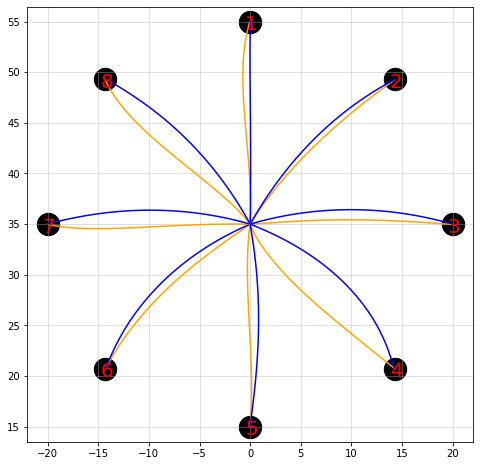

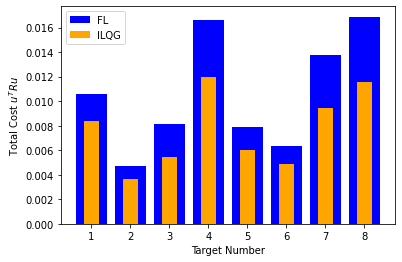

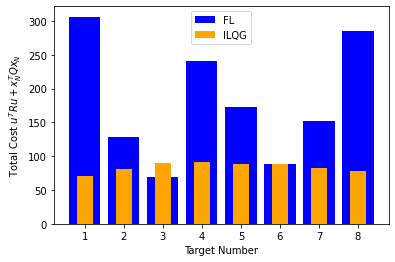

In [3]:
K = 60
Duration = .6
w1 = 1e8
w2 = 1e4
r1 = 1e-4
d = 14.285
start = [0,35]
fig,ax = plt.subplots(figsize = (8,8))
alpha = 1000
PLOT = False

TARG = [[0,55],[d,35+d],[20,35],[d,35-d],[0,15],[-d,35-d],[-20,35],[-d,35+d]]
TEXTE = [[0,56],[0,12],[21,35],[-22,35],[d+.5,35+d+.5],[d+.5,35-d-2.5],[-d-1.5,35-d-2.5],[-d-1.5,35+d+.5]]

COSTSFL = np.zeros(8)
MOTORCOSTSFL= np.zeros(8)
COSTSILQG = np.zeros(8)
MOTORCOSTSILQG= np.zeros(8)
NUMSIM = 500
NOISE = True
for sim in range(NUMSIM):
    for i in range(8):
        if sim==0:
            plt.scatter(TARG[i][0],TARG[i][1],color = "black",s = 500)
            plt.text(TARG[i][0]-.5,TARG[i][1]-.8,str(i+1),color = "red",size =  20)
            #plt.plot(np.linspace(start[0],TARG[i][0]),np.linspace(start[1],TARG[i][1]),label = str(i+1))

        targets = TARG[i]
        obj1,obj2 = newton(fnewton,dfnewton,1e-8,1000,targets[0],targets[1])
        xtarg = np.array([obj1,obj2])
        #plt.text(TEXTE[i][0],TEXTE[i][1],str(i))
        xILQG,yILQG,uILQG,x = ILQG(Duration,w1,w2,r1,targets,K,start,Noise = NOISE,plot = PLOT,alpha = alpha,multvar = 0)
    
        J = 0
        R = np.array([[r1,0],[0,r1]])
        for j in range(K-1):
            J+= uILQG[j].T@R@uILQG[j]
        MOTORCOSTSILQG[i]+=(J/NUMSIM)
        J+= w1*((x[-1,0]-xtarg[0])*(x[-1,0]-xtarg[0])+(x[-1,1]-xtarg[1])*(x[-1,1]-xtarg[1])) + w2*(x[-1,2]*x[-1,2]+x[-1,3]*x[-1,3])
        COSTSILQG[i]+=(J/NUMSIM)
        X,Y,J,x = Feedback_Linearization(Duration,w1,w1,w2,w2,r1,r1,targets,start,FF=False,alpha=alpha,newtonfunc = fnewton,newtondfunc = dfnewton,Num_iter = K,ShowJ=True,plot = PLOT,Activate_Noise=NOISE,Delay=0)
        if sim==0: 
            plt.plot(xILQG,yILQG,color = "orange",label = "ILQG")
            plt.plot(X,Y,color = "blue",label = "FL")
            plt.axis("equal")
            plt.grid(alpha = .5)
        MOTORCOSTSFL[i]+=(J/NUMSIM)
        J+= w1*((x[0]-xtarg[0])*(x[0]-xtarg[0])+(x[1]-xtarg[1])*(x[1]-xtarg[1])) + w2*(x[2]*x[2]+x[3]*x[3])
        COSTSFL[i]+=(J/NUMSIM)
        #print("Finished target "+str(i))
#for i in range(8):
    #print("For Target Number "+str(i+1)+"\n"+"Total Cost of FL : "+str(COSTSFL[i])+"\n"+"Total Cost of ILQG : "+str(COSTSILQG[i])+"\n")

plt.show()
plt.bar(np.arange(1,9,1),MOTORCOSTSFL,color = "blue",label = "FL")
plt.bar(np.arange(1,9,1),MOTORCOSTSILQG,color = "orange",width = .4,label = "ILQG")
plt.legend()
plt.ylabel("Total Cost $u^TRu$")
plt.xlabel("Target Number")
plt.show()
plt.bar(np.arange(1,9,1),COSTSFL,color = "blue",label = "FL")
plt.bar(np.arange(1,9,1),COSTSILQG,color = "orange",width = .4,label = "ILQG")
plt.legend()
plt.ylabel("Total Cost $u^TRu+x_N^TQx_N$")
plt.xlabel("Target Number")
plt.show()

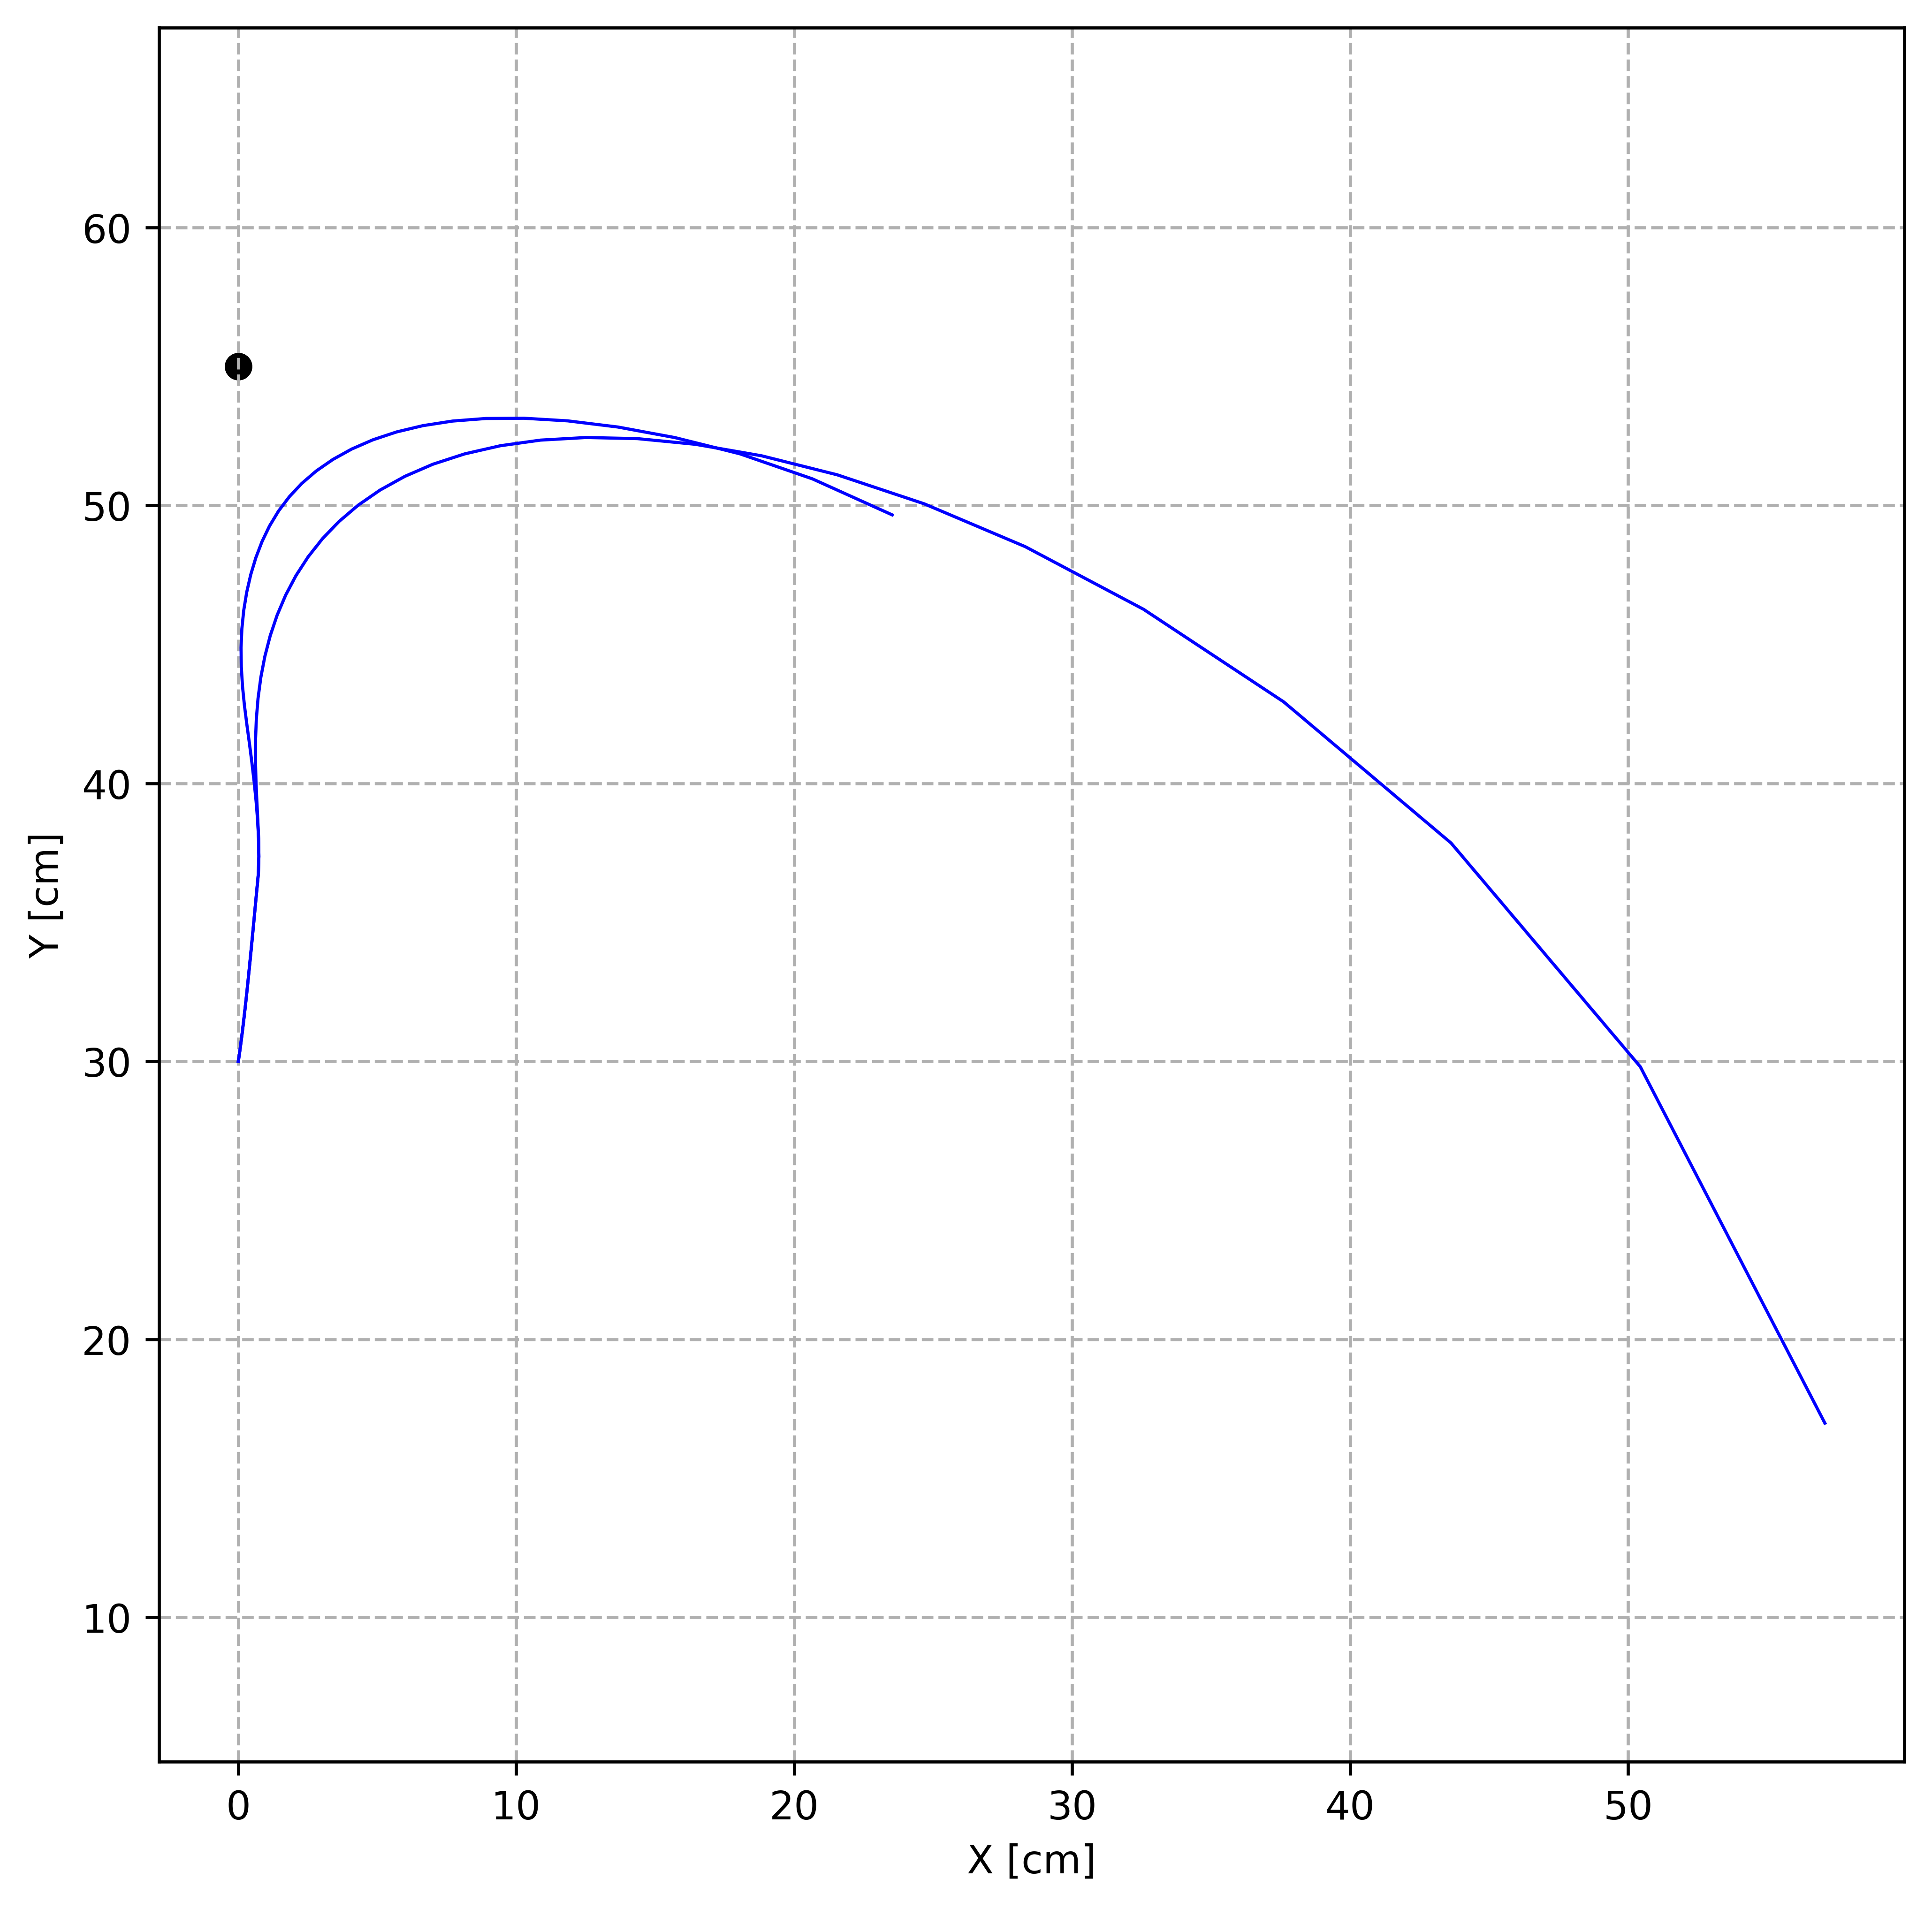

In [1]:
from Helpers import *
from ILQGController import *
plt.figure(dpi=600,figsize = (8,8))
xILQG,yILQG,uILQG,x = ILQG(.6,1e7,1e4,1e-4,[0,55],60,[0,30],Delay=0)
xILQG,yILQG,uILQG,x = ILQG(.6,1e7,1e4,1e-4,[0,55],60,[0,30],Delay=0.06)
    

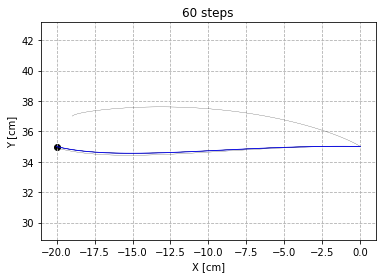

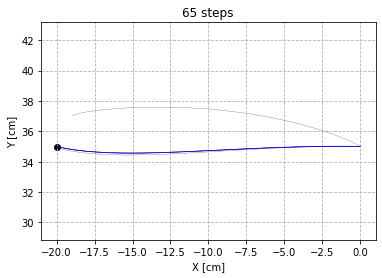

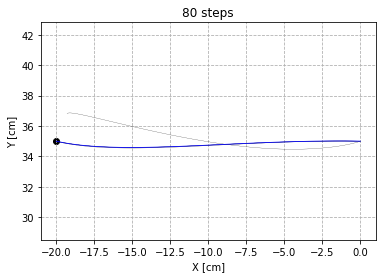

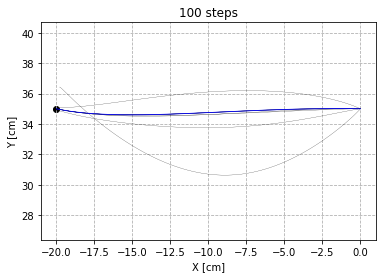

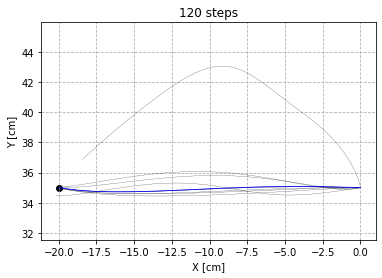

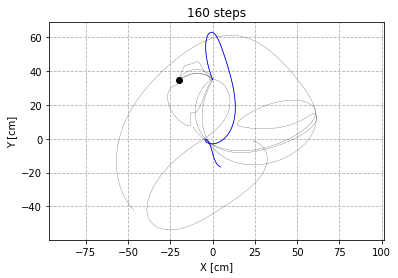

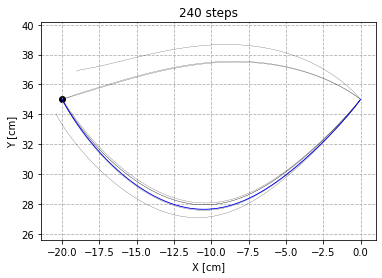

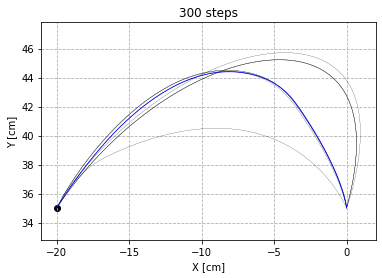

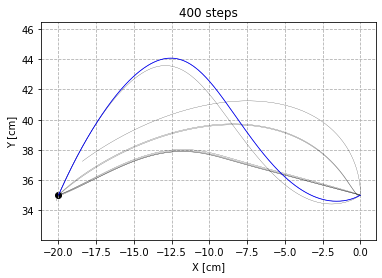

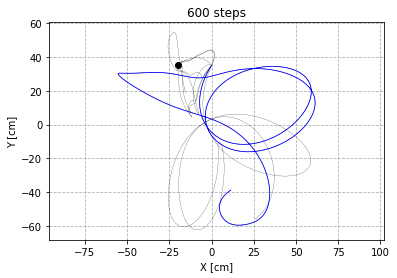

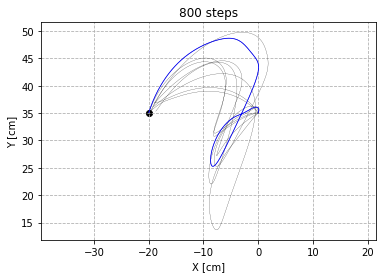

In [ ]:

targets = TARG[3]
obj1,obj2 = newton(fnewton,dfnewton,1e-8,1000,targets[0],targets[1])
xtarg = np.array([obj1,obj2])
#[60,65,80,100,120,160,240,300,400,600]
for K in [60,65,80,100,120,160,240,300,400,600,800]:
    plt.title(str(K)+" steps")
    xILQG,yILQG,uILQG,x = ILQG(Duration,w1,w2,r1,targets,K,start,Noise = False,plot = True,plotall = True,B = False)
    plt.show()
        

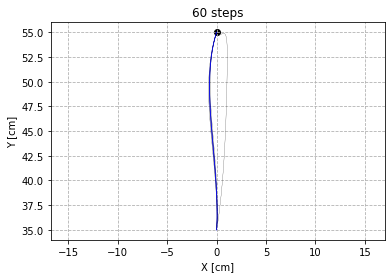

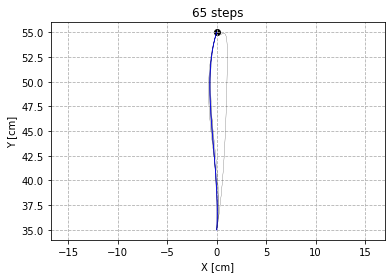

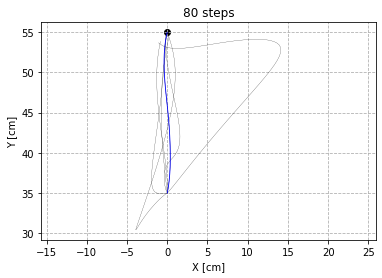

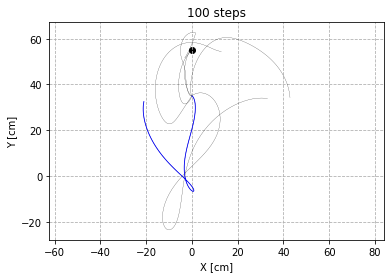

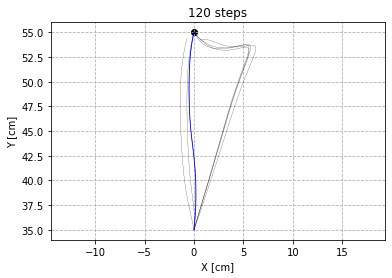

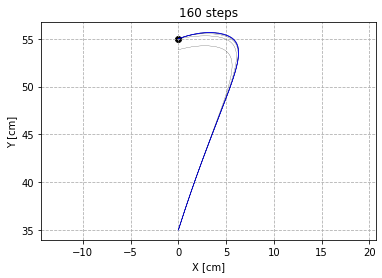

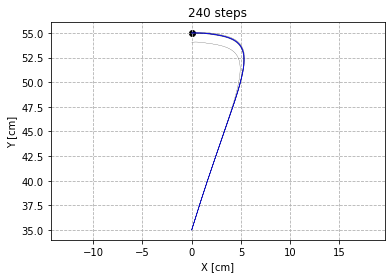

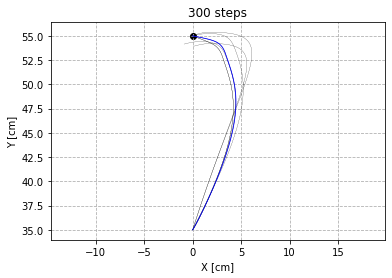

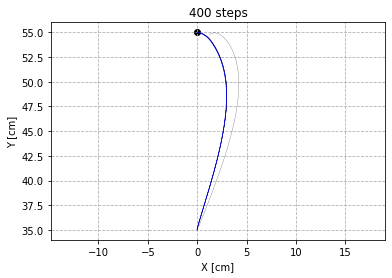

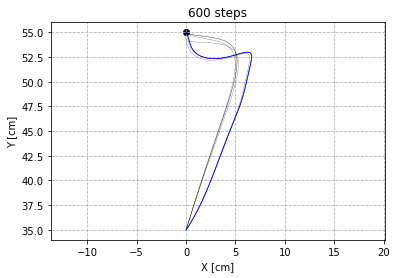

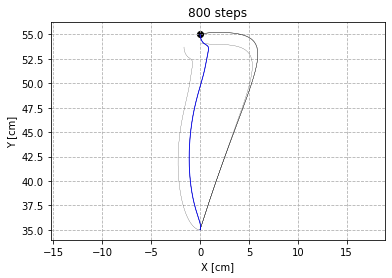

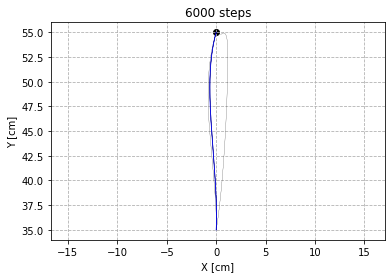

In [ ]:

targets = TARG[0]
obj1,obj2 = newton(fnewton,dfnewton,1e-8,1000,targets[0],targets[1])
xtarg = np.array([obj1,obj2])
#[60,65,80,100,120,160,240,300,400,600]
for K in [60,65,80,100,120,160,240,300,400,600,800,6000]:
    plt.title(str(K)+" steps")
    xILQG,yILQG,uILQG,x = ILQG(Duration,w1,w2,r1,targets,K,start,Noise = False,plot = True,plotall = True,B = False)
    plt.show()

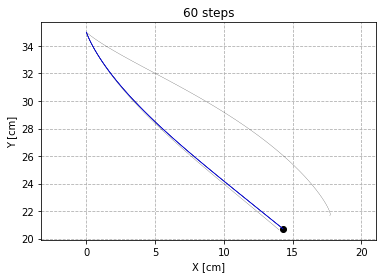

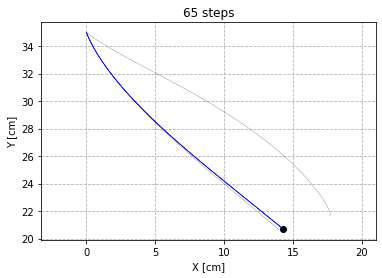

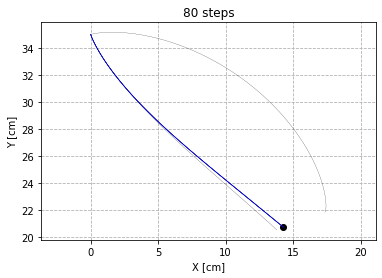

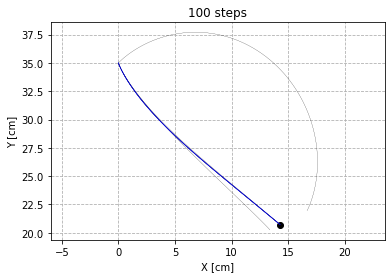

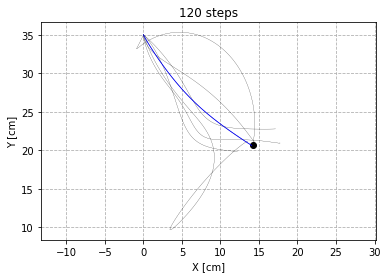

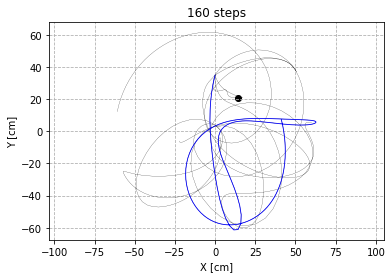

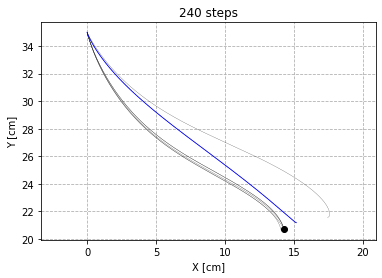

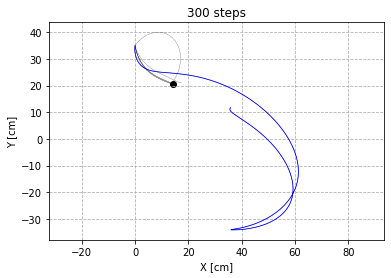

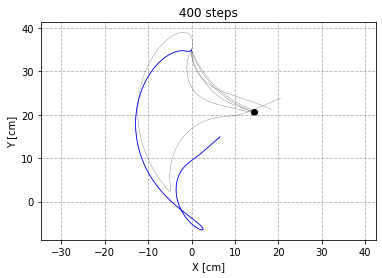

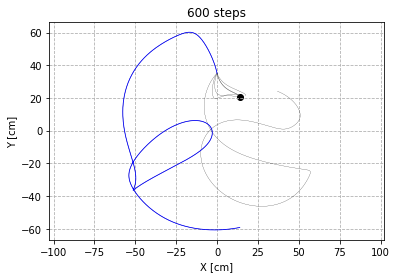

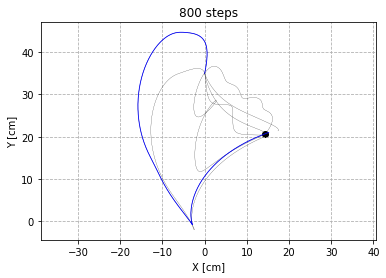

In [ ]:
targets = TARG[5]
obj1,obj2 = newton(fnewton,dfnewton,1e-8,1000,targets[0],targets[1])
xtarg = np.array([obj1,obj2])
#[60,65,80,100,120,160,240,300,400,600]
for K in [60,65,80,100,120,160,240,300,400,600,800,1600]:
    plt.title(str(K)+" steps")
    xILQG,yILQG,uILQG,x = ILQG(Duration,w1,w2,r1,targets,K,start,Noise = False,plot = True,plotall = True,B = False)
    plt.show()